# 2019-01-30 - Generer des courants pour le super ring

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import Spiking_LGN as SpiLGN
import MotionClouds as mc

import matplotlib.pyplot as plt
import imageio
import skimage.transform

from tqdm import tqdm

import datetime
now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H:%M:%S") 

# Transformer le protocole en npy

In [3]:
filename = './sequences/MC2019-01-30_10:54:51/MC_files.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')

In [4]:
vid_array = [] #Two times faster as a list than as an array
for img in tqdm(range(vid.get_length())):
    try :
        img = vid.get_data(img)
        vid_array.append(img[:,:,:]) #cutting off a black border
    except : 
        print('Empty frame error at frame %s' % img)
        pass

100%|██████████| 693/693 [00:00<00:00, 2721.15it/s]


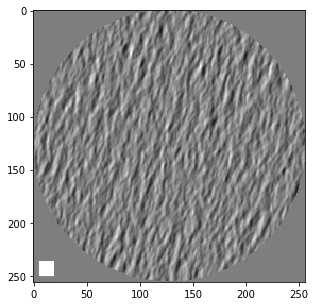

In [5]:
plt.figure(figsize = (8,5))
plt.imshow(vid_array[33])

In [6]:
# let's only keep the first color dimension since we're not interested
# in the role of color vision here. It saves a ton of memory too
gray_vid_array = []
for frame in range(len(vid_array)):
    gray_vid_array.append(vid_array[frame][:,:,0])

In [7]:
np.save('./sequences/MC%s_%sFPS' %(strtime,
                                   vid.get_meta_data()['fps']),
                                   gray_vid_array)

# Maintenant on réimporte la vidéo sauvegardée en numpy array

In [8]:
#first we import the video
video = np.load('./sequences/MC%s_%sFPS.npy' %(strtime,
                                   vid.get_meta_data()['fps']))

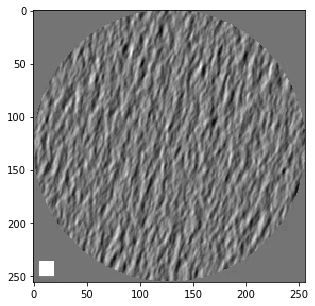

In [9]:
plt.figure(figsize = (8,5))
video = np.swapaxes(video, 0, -1)
video = np.swapaxes(video, 0, 1)
plt.imshow(video[:,:,33], cmap = plt.cm.gray)

# On génère les courants LGN

In [11]:
total_time = ( vid.get_length()/vid.get_meta_data()['fps'] ) * 1000
FPS = vid.get_meta_data()['fps']

In [12]:
output_currents = SpiLGN.input_to_currents(video=video, FPS=FPS, total_time=total_time,
                                           distrib_size=10, safeguard_offset=20, random_shift=1, grid_res=3,
                                           N_theta=4, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 5,
                                           off_gain = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)

Video shape (256, 256, 693)
Frames per second: 24.0
Frame duration at 24.0 FPS: 1203.12 ms
Video length inferred from fps: 29 s
Stimuli shape (256, 256, 28875)
Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 27.0min remaining: 27.0min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 27.0min remaining:    0.0s


KeyboardInterrupt: 

On vérifie que le format de sortie est bien N_orientations de gabor x N_positions x (Champs ON + Champs OFF)

In [ ]:
print('Output shape', np.asarray(output_currents).shape)
print('=(Thetas, Gabors, ON/OFF)')

Pour vérifier d'un coup d'oeil que les filtres ont bien marché on peut les visualiser comme des séries temporelles parallèles (et c'est plutot joli)

In [ ]:
#We show the second Theta (here pi/4) and third gabor (i.e. simple cell)
theta_display = 1
gabor_display = 3
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]

In [ ]:
import matplotlib.pyplot as plt
chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('white')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 25

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])
ax.set_xlabel('Time (ms)')
#plt.savefig('./figs/2018_11_08_Script_output_white.pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 

Et on resauvegarde les courants du modèle d'entrée histoire de pas avoir a les refaire calculer à chaque fois

In [ ]:
#Now we save the currents, in a numpy compressed array to save space (2.5x less size)
#tradeoff : saving twice as slow
import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")   
np.savez_compressed('./output/%s'%strtime, output_currents)

In [ ]:
#the loading method is a bit different as the npz can dump multiple arrays
load_npz = np.load('./output/%s.npz'%strtime)
load_arr = load_npz['arr_0.npy'] #won't contain more than one array normally

Chaque sous fonction est également visualisable en l'appellant par SpiLGN.nom_de_la_fonction. Par exemple, on peut visualiser les coordonées des centroides, qui sont les points autour desquels sont distribués les champs récepteurs

In [ ]:
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

coor = SpiLGN.generate_centers_coordinates(
        distrib_size=10, safeguard_offset = 12, random_shift = 1, video=video)


fig = plt.figure(figsize = (8,6))

#la taille des points n'est pas une science exacte
plt.scatter(coor[0], coor[1], s = 82**2, edgecolor = 'black') 


plt.imshow(video[:,:,0], cmap = plt.cm.binary)
plt.title('Centroids distribution\nSome filters are still likely outside the boundaries')